In [73]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import tensorflow_datasets as tfds

# 데이터 불러오기

In [1]:
# train, test 데이터 불러오기

train_path1 = './augment data/augmented_inserted_text_data.csv' # 필요에 따라 변경하세요.
train_path2 = './augment data/augmented_replaced_text_data.csv' # 필요에 따라 변경하세요.
train_path3 = './augment data/raw_data.csv' # 필요에 따라 변경하세요.
test_path = './data/test.csv' # 필요에 따라 변경하세요.
# train_normal_data_path = './data/일반대화 합성데이터(GPT-4o, AIhub 참고).csv'

def load_data(file_path):
    df = pd.read_csv(file_path)
    
    return df

train_df1 = load_data(train_path1)
train_df2 = load_data(train_path2)
train_df3 = load_data(train_path3)
test_df = load_data(test_path)
# normal_df = load_data(train_normal_data_path)

NameError: name 'pd' is not defined

In [2]:
train_df3.shape

NameError: name 'train_df3' is not defined

In [3]:
train_df3 = train_df3.drop_duplicates(subset=['conversation'])
train_df3 = train_df3.sample(frac=1, random_state=None).reset_index(drop=True)
val_df = train_df3.iloc[:4846//10, ]
test_df = train_df3.iloc[4846//10:4846//10*2, ]
train_df3 = train_df3.iloc[4846//10*2:, ]
val_df.shape, test_df.shape, train_df3.shape


NameError: name 'train_df3' is not defined

In [77]:
# 데이터 확인
# train_df.shape, test_df.shape # , normal_df.shape

In [78]:
# train data 와 normal 데이터 합치기
def concat_train_normal(df_list):
    train_df = pd.concat(df_list, ignore_index=True)
#     train_df.drop(['idx'], axis=1, inplace=True)
    train_df.reset_index(inplace=True)

    return train_df

df_list = [train_df1, train_df2, train_df3]
train_df = concat_train_normal(df_list)
train_df.shape, train_df.head()

((11286, 5),
    level_0      class  class_encoded  \
 0        0      협박 대화              0   
 1        1      협박 대화              0   
 2        2  기타 괴롭힘 대화              3   
 3        3      갈취 대화              1   
 4        4      갈취 대화              1   
 
                                         conversation  index  
 0  왜 지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면...    NaN  
 1  길동경찰서입니다. 9시 40분 마트에 폭발물을 하나 더 설치할거다.? 네? 똑바로 ...    NaN  
 2  너 되게 귀여운거 알지? 나보다 키 작은 남자는 첨봤어. 그만해. 니들 놀리는거 진...    NaN  
 3  어이 거기 예?? 너 말이야 너. 너 이리 오라고 무슨 일. 너 옷 좋아보인다? 얘...    NaN  
 4  저기요 혹시 날이 너무 많이 뜨겁잖아요? 저희 회사에서 지금 이 선크림 파는데 한 ...    NaN  )

In [79]:
train_df = train_df[['conversation', 'class', 'class_encoded']]
val_df = val_df[['conversation', 'class', 'class_encoded']]
test_df = test_df[['conversation', 'class', 'class_encoded']]
train_df.head()

,conversation,class,class_encoded
0,왜 지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면...,협박 대화,0
1,길동경찰서입니다. 9시 40분 마트에 폭발물을 하나 더 설치할거다.? 네? 똑바로 ...,협박 대화,0
2,너 되게 귀여운거 알지? 나보다 키 작은 남자는 첨봤어. 그만해. 니들 놀리는거 진...,기타 괴롭힘 대화,3
3,어이 거기 예?? 너 말이야 너. 너 이리 오라고 무슨 일. 너 옷 좋아보인다? 얘...,갈취 대화,1
4,저기요 혹시 날이 너무 많이 뜨겁잖아요? 저희 회사에서 지금 이 선크림 파는데 한 ...,갈취 대화,1


In [80]:
# # 클래스 숫자로 변환
# def class_encoding(train_df, class_mapping):
#     train_df['class_encoded'] = train_df['class'].replace(class_mapping)
    
#     return train_df

# # 클래스 매핑 딕셔너리 정의
# class_mapping = {
#     "협박 대화": 0,
#     "갈취 대화": 1,
#     "직장 내 괴롭힘 대화": 2,
#     "기타 괴롭힘 대화": 3 # ,
# #     "일반 대화": 4
# }

# train_df = class_encoding(train_df, class_mapping)

# # 변환된 데이터 확인
# train_df.head()


In [81]:
train_df.shape, val_df.shape, test_df.shape

((11286, 3), (1615, 3), (1615, 3))

In [82]:
# 중복된 'conversation' 제거
train_df = train_df.drop_duplicates(subset=['conversation'])
val_df = val_df.drop_duplicates(subset=['conversation'])
test_df = test_df.drop_duplicates(subset=['conversation'])

# 중복 제거 후 데이터 확인
train_df.shape, val_df.shape, test_df.shape

((11286, 3), (1615, 3), (1615, 3))

In [83]:
# from sklearn.model_selection import train_test_split

# # 1️⃣ 먼저 데이터를 섞기
# train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# # 2️⃣ 60%: 훈련 데이터 분할
# train_data, temp_data = train_test_split(train_df, test_size=0.4, random_state=42, stratify=train_df['class_encoded'])

# # 3️⃣ 남은 40% 중 50%를 검증, 50%를 테스트로 나누기 (즉, 20%씩)
# val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, stratify=temp_data['class_encoded'])

# # 4️⃣ 결과 확인
# print(f"Train size: {len(train_data)}, Validation size: {len(val_data)}, Test size: {len(test_data)}")


# 전처리

In [84]:
# 전처리 함수
def preprocess_sentence(sentence):
  # 입력받은 sentence를 소문자로 변경하고 양쪽 공백을 제거
  sentence = sentence.lower().strip()

  # 개행 문자("\n")를 공백으로 변환
  sentence = re.sub(r"\n", " ", sentence)
    
  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence) # ?.!, 앞뒤로 공백 추가
  sentence = re.sub(r'[" "]+', " ", sentence) # 연속된 공백 한개의 공백으로

  # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r"[^a-zA-Z\u1100-\u11FF\uAC00-\uD7AF.,?!]", " ", sentence)
  sentence = sentence.strip()
  return sentence

In [85]:
conversation = train_df['conversation'].apply(preprocess_sentence)
conversation

0        왜 지금 너 스스로를 죽여달라고 애원하는 것인가 ? 아닙니다 . 죄송합니다 . 죽을...
1        길동경찰서입니다 .  시   분 마트에 폭발물을 하나 더 설치할거다 . ? 네 ? ...
2        너 되게 귀여운거 알지 ? 나보다 키 작은 남자는 첨봤어 . 그만해 . 니들 놀리는...
3        어이 거기 예 ? ? 너 말이야 너 . 너 이리 오라고 무슨 일 . 너 옷 좋아보인...
4        저기요 혹시 날이 너무 많이 뜨겁잖아요 ? 저희 회사에서 지금 이 선크림 파는데 한...
                               ...                        
11281    다음 주 목금 휴가 쓰면 완전 연휴 길더라 ? 와 내가 그렇게 쓰려다가 빠꾸당함 ....
11282    그래도 가족들이 많이 믿어주고 그래서 열심히 할 수 있는 거 같으면서도 부담스럽기도...
11283    시간 얼마 안남았어 알고 있습니다 . 시간 넘기면 안돼 노력 해보겠습니다 . 노력 ...
11284    인정 그리고 난 결혼하면 고양이 키울 거라 너 비염 치료해야 해 안돼 고양이 강아지...
11285    빌린돈 언제 갚을건데 조만간갚겟습니다  달만 시간을주세요 그건좀 곤란한데 지금 돈구...
Name: conversation, Length: 11286, dtype: object

In [86]:
# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(conversation, target_vocab_size=20000)

In [87]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

20684


In [88]:
# 1998번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 1998번째 질문 샘플: {}'.format(tokenizer.encode(conversation[1998])))

정수 인코딩 후의 1998번째 질문 샘플: [34, 8450, 476, 4691, 1471, 1, 16, 3852, 2, 106, 1910, 666, 1797, 12941, 15, 9893, 2032, 9, 19385, 27, 4987, 137, 1, 134, 2062, 837, 1, 66, 53, 2032, 699, 539, 53, 7375, 446, 2, 11672, 44, 2940, 17774, 7917, 69, 1, 34, 534, 20663, 20556, 20609, 44, 989, 14325, 36, 5334, 1, 3369, 1, 147, 9216, 2870, 979, 6332, 876, 2858, 1, 335, 17429, 493, 9315, 1, 90, 10139, 2714, 5098, 405, 201, 1595, 3126, 66, 82, 47, 6988, 1775, 233, 3026, 2849, 9772, 1, 1752, 2, 544, 26, 12818, 20458, 5863, 1, 498, 1, 34, 430, 8324, 30, 337, 9459, 288, 1325, 8754, 1767, 1, 7274, 25]


In [89]:
# 원본 확인
conversation[1998].split()

['그',
 '학생이',
 '잠깐',
 '이리로',
 '와봐',
 '.',
 '왜',
 '그러시죠',
 '?',
 '요즘',
 '부모들은',
 '어린',
 '애들한테도',
 '명품',
 '옷을',
 '좀',
 '사준다고',
 '하더니',
 '.',
 '진짜였군',
 '.',
 '제가',
 '무슨',
 '옷을',
 '입든',
 '무슨',
 '상관이에요',
 '?',
 '학생들은',
 '학생답게',
 '다녀야지',
 '.',
 '그',
 '재킷은',
 '오늘부로',
 '내',
 '거다',
 '.',
 '싫어요',
 '.',
 '제',
 '생일선물로',
 '겨우',
 '받은',
 '옷이란',
 '말이에요',
 '.',
 '일을',
 '복잡하게',
 '되게',
 '만드네',
 '.',
 '이렇게',
 '험한',
 '꼴',
 '당하고',
 '싶어',
 '?',
 '.',
 '아뇨',
 '그치만',
 '제가',
 '정말',
 '많이',
 '아끼는',
 '옷인데',
 '이번만',
 '봐주시면',
 '.',
 '안될까요',
 '?',
 '좋아',
 '그럼',
 '인심',
 '썼다',
 '.',
 '그럼',
 '.',
 '그',
 '옷',
 '대신',
 '만원',
 '가져와봐',
 '.',
 '.',
 '엄마한테',
 '문자할게요',
 '.',
 '잠시만요',
 '.']

In [90]:
# 각 데이터의 토큰 개수 세기
temp = list(map(lambda x : len(x.split()), conversation))
temp[:5]

[76, 56, 73, 48, 156]

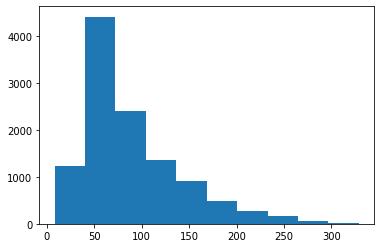

In [91]:
# 각 데이터의 토큰 개수 시각화 - histplot
import matplotlib.pyplot as plt

plt.hist(temp)
plt.show()

In [92]:
print(f'MAX_LENGTH = 200 일때: {np.array([True if x <= 200 else False for x in temp]).sum() / len(conversation) * 100:.2f} %')
print(f'MAX_LENGTH = 100 일때: {np.array([True if x <= 100 else False for x in temp]).sum() / len(conversation) * 100:.2f} %')
print(f'MAX_LENGTH = 50 일때: {np.array([True if x <= 50 else False for x in temp]).sum() / len(conversation) * 100:.2f} %')

MAX_LENGTH = 200 일때: 95.53 %
MAX_LENGTH = 100 일때: 69.48 %
MAX_LENGTH = 50 일때: 23.10 %


In [93]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 100
print(MAX_LENGTH)

100


In [94]:
# 최대 길이를 초과하는 샘플은 데이터 자르기, 패딩
def tokenize_and_filter(inputs):
  tokenized_inputs = list()
  
  for sentence in inputs:
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence = tokenizer.encode(sentence)

    # 최대 길이 200 까지만 데이터셋으로 사용
    if len(sentence) <= MAX_LENGTH:
      tokenized_inputs.append(sentence)
    
    else:
      tokenized_inputs.append(sentence[:MAX_LENGTH])
  
  # 최대 길이 200으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs

In [95]:
conversation = tokenize_and_filter(conversation)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 대화 샘플 개수: {}'.format(len(conversation)))

단어장의 크기 : 20684
필터링 후의 대화 샘플 개수: 11286


# 모델링 - transformer 인코딩 모델 밑바닥부터 구현하기

In [96]:
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

# 멀티 헤드 어텐션 구현하기
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

# 패딩 마스크 구현 함수
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

# 인코더 생성하기
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [97]:
# 인코더만 구성하기
def my_encoder(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="my_encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # Global Average Pooling 적용 (or Max Pooling 가능)
  outputs = tf.keras.layers.GlobalMaxPooling1D()(enc_outputs)

  # 완전연결층
  outputs = tf.keras.layers.Dense(256, activation="relu", name='dense1')(outputs)
  outputs = tf.keras.layers.Dropout(0.3)(outputs)  # 🔥 드롭아웃 추가 (30%)
  outputs = tf.keras.layers.Dense(128, activation="relu", name='dense2')(outputs)
  outputs = tf.keras.layers.Dropout(0.3)(outputs)  # 🔥 드롭아웃 추가 (30%)
  outputs = tf.keras.layers.Dense(units=5, activation="softmax", name='outputs')(outputs)

  return tf.keras.Model(inputs=inputs, outputs=outputs, name=name)

In [98]:
# 모델 생성하기
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = my_encoder(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "my_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    6349312     inputs[0][0]                     
                                                                 enc_padding_mask[0][0]           
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 256)          0           encoder[0][0]           

In [99]:
# 커스텀 학습률 스케줄링(Custom Learning rate Scheduling)
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [100]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# EarlyStopping & ModelCheckpoint 설정
early_stopping = EarlyStopping(
    monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)

model_checkpoint = ModelCheckpoint(
    "best_model", monitor='val_loss', save_best_only=True, mode='max', verbose=1, save_format="tf", save_weights_only=True)

callbacks = [early_stopping, model_checkpoint]


In [101]:
# 모델 컴파일
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=["accuracy"])

In [102]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000

def get_dataset(data):
    conversation = data['conversation'].apply(preprocess_sentence)
    conversation = tokenize_and_filter(conversation)

    dataset = tf.data.Dataset.from_tensor_slices((
    {'inputs': conversation},  # 입력 데이터
    {'outputs': data['class_encoded'].values}  # 출력 데이터 (라벨)
    ))
    
    dataset = dataset.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    
    return dataset

train_dataset = get_dataset(train_df)
val_dataset = get_dataset(val_df)
test_dataset = get_dataset(test_df)

Epoch 1/100
177/177 [==============================] - 9s 40ms/step - loss: 2.0446 - accuracy: 0.2058 - val_loss: 1.5759 - val_accuracy: 0.3573

Epoch 00001: val_loss improved from -inf to 1.57589, saving model to best_model
Epoch 2/100
177/177 [==============================] - 7s 37ms/step - loss: 1.7155 - accuracy: 0.2051 - val_loss: 1.5843 - val_accuracy: 0.2372

Epoch 00002: val_loss improved from 1.57589 to 1.58427, saving model to best_model
Epoch 3/100
177/177 [==============================] - 7s 38ms/step - loss: 1.6776 - accuracy: 0.2348 - val_loss: 1.5636 - val_accuracy: 0.3325

Epoch 00003: val_loss did not improve from 1.58427
Epoch 4/100
177/177 [==============================] - 7s 38ms/step - loss: 1.4360 - accuracy: 0.3416 - val_loss: 1.1954 - val_accuracy: 0.3517

Epoch 00004: val_loss did not improve from 1.58427
Epoch 5/100
177/177 [==============================] - 7s 38ms/step - loss: 1.1410 - accuracy: 0.4501 - val_loss: 0.9418 - val_accuracy: 0.5820

Epoch 0000

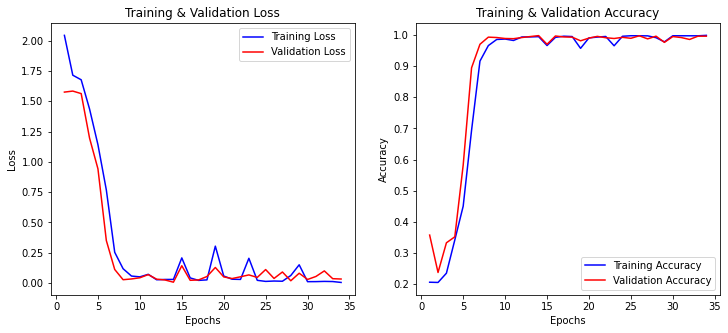

In [103]:
import matplotlib.pyplot as plt

# 모델 학습 실행 (history 저장)
EPOCHS = 100
history = model.fit(
    train_dataset, 
    validation_data=val_dataset, 
    epochs=EPOCHS, 
    callbacks=callbacks
)

# 학습 결과(history) 가져오기
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history.get('accuracy', history.history.get('acc'))  # 'accuracy' 또는 'acc' 키 확인
val_acc = history.history.get('val_accuracy', history.history.get('val_acc'))  # 'val_accuracy' 또는 'val_acc' 키 확인

# 에포크 값 생성
epochs = range(1, len(train_loss) + 1)

# Loss 그래프
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()


In [104]:
# test_dataset에서 X, y 추출

# X와 y 리스트 생성
X_train = []
y_train = []

# test_dataset에서 inputs(X)와 outputs(y) 추출
for x, y in train_dataset:
    X_train.extend(x['inputs'].numpy())  # X 값 (입력 데이터)
    y_train.extend(y['outputs'].numpy())  # y 값 (라벨 데이터)

# 리스트를 NumPy 배열로 변환
X_train = np.array(X_train)
y_train = np.array(y_train)

pd.value_counts(y_train)


3    2344
4    2316
1    2286
2    2236
0    2104
dtype: int64

In [105]:
# test_dataset에서 X, y 추출

# X와 y 리스트 생성
X_val = []
y_val = []

# test_dataset에서 inputs(X)와 outputs(y) 추출
for x, y in val_dataset:
    X_val.extend(x['inputs'].numpy())  # X 값 (입력 데이터)
    y_val.extend(y['outputs'].numpy())  # y 값 (라벨 데이터)

# 리스트를 NumPy 배열로 변환
X_val = np.array(X_val)
y_val = np.array(y_val)

pd.value_counts(y_val)


3    383
2    351
4    302
1    299
0    280
dtype: int64

In [106]:
# test_dataset에서 X, y 추출

# X와 y 리스트 생성
X_test = []
y_test = []

# test_dataset에서 inputs(X)와 outputs(y) 추출
for x, y in test_dataset:
    X_test.extend(x['inputs'].numpy())  # X 값 (입력 데이터)
    y_test.extend(y['outputs'].numpy())  # y 값 (라벨 데이터)

# 리스트를 NumPy 배열로 변환
X_test = np.array(X_test)
y_test = np.array(y_test)

pd.value_counts(y_test)


4    360
1    334
2    323
3    306
0    292
dtype: int64

In [107]:
# X 데이터 합치기
temp = np.concatenate([X_train, X_val, X_test], axis=0)
temp.shape

(14516, 100)

In [108]:
# X 데이터 중복값 확인(데이터 누출 확인)
np.unique(temp, axis=0).shape

(14515, 100)

# Test dataset으로 확인하기

In [109]:
# 모델 평가 (train_dataset을 사용)
model.evaluate(train_dataset)

177/177 [==============================] - 2s 13ms/step - loss: 0.0060 - accuracy: 0.9993


[0.006037597078830004, 0.999291181564331]

In [110]:
# 모델 평가 (validation_dataset을 사용)
model.evaluate(val_dataset)

26/26 [==============================] - 0s 13ms/step - loss: 0.0056 - accuracy: 0.9981


[0.005553610622882843, 0.998142421245575]

In [111]:
# 모델 평가 (test_dataset을 사용)
model.evaluate(test_dataset)

26/26 [==============================] - 0s 13ms/step - loss: 0.0142 - accuracy: 0.9975


[0.014207848347723484, 0.9975232481956482]

In [112]:
# test_dataset에서 X, y 추출

# X와 y 리스트 생성
X_test = []
y_test = []

# test_dataset에서 inputs(X)와 outputs(y) 추출
for x, y in test_dataset:
    X_test.extend(x['inputs'].numpy())  # X 값 (입력 데이터)
    y_test.extend(y['outputs'].numpy())  # y 값 (라벨 데이터)

# 리스트를 NumPy 배열로 변환
X_test = np.array(X_test)
y_test = np.array(y_test)

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_test shape: (1615, 100)
y_test shape: (1615,)


In [113]:
def get_pred(X_test):
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=-1)
    
    return y_pred

y_pred = get_pred(X_test)
y_pred[:5]

array([4, 3, 4, 2, 4])

In [114]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.9966    0.9966    0.9966       292
           1     1.0000    0.9970    0.9985       334
           2     1.0000    0.9938    0.9969       323
           3     0.9903    1.0000    0.9951       306
           4     1.0000    1.0000    1.0000       360

    accuracy                         0.9975      1615
   macro avg     0.9974    0.9975    0.9974      1615
weighted avg     0.9975    0.9975    0.9975      1615



# 추론 및 Submission 저장

In [32]:
def make_submission_df(model, test_df):
    test_conversation = test_df['text'].apply(preprocess_sentence)
    test_conversation = tokenize_and_filter(test_conversation)
    
    y_pred = get_pred(test_conversation)
    
    test_df['target'] = y_pred
    test_df.drop(['text'], axis=1, inplace=True)
    
    return test_df

test_df = make_submission_df(model, test_df)
test_df.to_csv('my_submission.csv', index=False)
test_df.head()

,idx,target
0,t_000,1
1,t_001,2
2,t_002,2
3,t_003,2
4,t_004,3
